In [1]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/CIP/MODEL"

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to load and preprocess images
def load_and_preprocess_images(dataset_path, img_size=(227, 227)):
    categories = ["Normal", "Abnormal", "MI", "History_MI"]
    data, labels = [], []
    class_map = {cat: i for i, cat in enumerate(categories)}

    for category in categories:
        path = os.path.join(dataset_path, category)
        if not os.path.exists(path):
            print(f"Warning: Folder {path} not found!")
            continue

        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Unable to read image {img_path}")
                continue  # Skip unreadable images
            img = cv2.resize(img, img_size)  # Resize to (227, 227)
            img = img / 255.0  # Normalize to [0,1]

            data.append(img)
            labels.append(class_map[category])

    data = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)
    return data, labels

# Load and preprocess dataset
dataset_path = "/content/drive/MyDrive/CIP/MODEL/ECG_Dataset"  # Change to your dataset path
data, labels = load_and_preprocess_images(dataset_path)

# Train-validation split (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

# Calculate class weights to handle imbalanced classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Data Augmentation
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator
data_generator.fit(X_train)

# Print dataset details
print(f"Training set: {len(X_train)} images, Validation set: {len(X_val)} images")
print(f"Class weights: {class_weight_dict}")

Training set: 742 images, Validation set: 186 images
Class weights: {0: 0.8171806167400881, 1: 0.9973118279569892, 2: 0.9712041884816754, 3: 1.3442028985507246}


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate, BatchNormalization, LeakyReLU, Reshape, UpSampling2D

def build_proposed_cnn(input_shape=(227, 227, 3), num_classes=4):
    input_layer = Input(shape=input_shape)

    # Stack Branch
    x = Conv2D(64, (3, 3), padding='same')(input_layer)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((6, 6), strides=3)(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((6, 6), strides=3)(x)

    x = Conv2D(224, (3, 3), padding='same')(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((6, 6), strides=3)(x)

    stack_branch_output = x  # Shape: (None, 6, 6, 224)

    # Full Branch
    y = Dense(16)(Flatten()(input_layer))
    y = LeakyReLU(negative_slope=0.1)(y)
    y = BatchNormalization()(y)
    y = Dropout(0.5)(y)

    # Reshape the Dense layer output to a 4D tensor for Conv2D
    y = Reshape((1, 1, 16))(y)  # Shape: (None, 1, 1, 16)

    y1 = Conv2D(32, (2, 2), strides=1, padding='same')(y)
    y2 = Conv2D(64, (3, 3), strides=2, padding='same')(y)
    y = concatenate([y1, y2])  # Shape: (None, 1, 1, 96)
    y = Dropout(0.5)(y)

    # Upsample the Full Branch output to match the Stack Branch spatial dimensions
    y = UpSampling2D(size=(6, 6))(y)  # Shape: (None, 6, 6, 96)

    # Concatenate branches along the channel dimension
    combined = concatenate([stack_branch_output, y])  # Shape: (None, 6, 6, 224 + 96)
    combined = Conv2D(256, (1, 1))(combined)
    combined = Flatten()(combined)
    combined = Dense(512)(combined)
    combined = Dropout(0.5)(combined)
    output_layer = Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Build and compile the model
model = build_proposed_cnn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 227, 227, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 227, 227, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 227, 227, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 227, 227, 64)   │            256 │ leaky_re_lu[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 154587)         │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 74, 74, 64)     │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │      2,473,408 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 74, 74, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 16)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 74, 74, 128)    │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16)             │             64 │ leaky_re_lu_3[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 74, 74, 128)    │            512 │ leaky_re_lu_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 16)             │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 23, 23, 128)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 16)       │              0 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 23, 23, 224)    │        258,272 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 1, 1, 32)       │          2,080 │ reshape[0][0]          │
├──────────────────────

 Total params: 7,623,748 (29.08 MB)

 Trainable params: 7,622,884 (29.08 MB)

 Non-trainable params: 864 (3.38 KB)

In [10]:
import json
import os
import pickle
from tensorflow.keras.callbacks import CSVLogger, Callback
from tensorflow.keras.models import load_model

# -----------------------------------
# File paths for model and tracking
# -----------------------------------
best_accuracy_file = '/content/drive/MyDrive/CIP/MODEL/best_accuracy.json'
log_file = '/content/drive/MyDrive/CIP/MODEL/training_log.csv'
model_save_path = '/content/drive/MyDrive/CIP/MODEL/best_model.h5'

# -----------------------------------
# Load the stored best accuracy BEFORE training starts
# -----------------------------------
if os.path.exists(best_accuracy_file):
    try:
        with open(best_accuracy_file, 'r') as f:
            data = json.load(f)
            stored_best_accuracy = data.get('best_accuracy', 0.0)
        print(f"✅ Previously saved best validation accuracy: {stored_best_accuracy:.4f}")
    except (json.JSONDecodeError, IOError):
        print("⚠️ Warning: Failed to read best accuracy. Resetting to 0.0")
        stored_best_accuracy = 0.0
else:
    stored_best_accuracy = 0.0

# -----------------------------------
# Custom Callback to Save Best Accuracy & Model
# -----------------------------------
class SaveBestAccuracy(Callback):
    def __init__(self, filepath):
        super(SaveBestAccuracy, self).__init__()
        self.filepath = filepath
        self.best_accuracy = stored_best_accuracy  # ✅ Initialize with stored best accuracy

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get('val_accuracy')
        if current_accuracy is not None and current_accuracy > self.best_accuracy:
            print(f"\n🏆 Validation accuracy improved from {self.best_accuracy:.4f} to {current_accuracy:.4f}. Saving model...")
            self.best_accuracy = current_accuracy
            # Save updated best accuracy to JSON
            with open(self.filepath, 'w') as f:
                json.dump({'best_accuracy': self.best_accuracy}, f)
            # Save the best model
            self.model.save(model_save_path)

# -----------------------------------
# CSV Logger for Epoch-wise Training Log
# -----------------------------------
csv_logger = CSVLogger(log_file, append=True)
save_best_accuracy = SaveBestAccuracy(best_accuracy_file)

# -----------------------------------
# Build Model and Load Best Weights if Available
# -----------------------------------
# Make sure to define 'build_38_layer_cnn' elsewhere in your code
model = build_proposed_cnn()

# ✅ Load existing best model weights if available
if os.path.exists(model_save_path):
    print(f"✅ Found saved best model. Loading weights from {model_save_path}")
    model.load_weights(model_save_path)
else:
    print("ℹ️ No saved model found. Starting fresh training.")

# -----------------------------------
# Compile Model
# -----------------------------------
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# -----------------------------------
# Confirmation Before Training Starts
# -----------------------------------
print(f"📌 Training will continue from last best validation accuracy: {stored_best_accuracy:.4f}")

# -----------------------------------
# Train the Model
# -----------------------------------
history = model.fit(
    data_generator.flow(X_train, y_train, batch_size=32),  # Ensure data_generator is defined earlier
    validation_data=(X_val, y_val),
    epochs=30,  # Set appropriate number of epochs
    class_weight=class_weight_dict,  # Ensure class_weight_dict is defined earlier
    callbacks=[csv_logger, save_best_accuracy]  # Save model if validation accuracy improves
)

# -----------------------------------
# Load Best Model and Accuracy After Training
# -----------------------------------
best_model = load_model(model_save_path)  # Load best model for evaluation or future use

# ✅ Load and Print Final Best Accuracy
if os.path.exists(best_accuracy_file):
    try:
        with open(best_accuracy_file, 'r') as f:
            data = json.load(f)
            best_accuracy = data.get('best_accuracy', 0.0)
        print(f"🏆 Final best validation accuracy achieved: {best_accuracy:.4f}")
    except (json.JSONDecodeError, IOError):
        print("⚠️ Warning: Failed to read best accuracy.")

# -----------------------------------
# Save Training History for Plotting/Analysis
# -----------------------------------
with open('/content/drive/MyDrive/CIP/MODEL/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


✅ Previously saved best validation accuracy: 0.9892
✅ Found saved best model. Loading weights from /content/drive/MyDrive/CIP/MODEL/best_model.h5
📌 Training will continue from last best validation accuracy: 0.9892


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 248s 10s/step - accuracy: 0.8722 - loss: 0.7470 - val_accuracy: 0.7581 - val_loss: 3.2346
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 264s 10s/step - accuracy: 0.8805 - loss: 0.8151 - val_accuracy: 0.6613 - val_loss: 4.2424
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 233s 10s/step - accuracy: 0.9222 - loss: 0.5190 - val_accuracy: 0.9032 - val_loss: 0.7085
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 263s 10s/step - accuracy: 0.9291 - loss: 0.3516 - val_accuracy: 0.7366 - val_loss: 1.8262
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 232s 10s/step - accuracy: 0.9108 - loss: 0.4957 - val_accuracy: 0.9409 - val_loss: 0.8065
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 234s 10s/step - accuracy: 0.9110 - loss: 0.4679 - val_accuracy: 0.8710 - val_loss: 1.2516
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 232s 10s/step - accuracy: 0.9231 - loss: 0.4226 - val_accuracy: 0.8118 - val_loss: 1.6456
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 262s 10s/step - accuracy: 0.9214 - loss: 0.3711 - val_accuracy: 0.

KeyboardInterrupt: 

24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step

🔷 Training and evaluating SVM...

✅ SVM Accuracy: 98.92%

📊 Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        57
    Abnormal       0.98      0.98      0.98        47
          MI       1.00      1.00      1.00        48
  History_MI       0.97      0.97      0.97        34

    accuracy                           0.99       186
   macro avg       0.99      0.99      0.99       186
weighted avg       0.99      0.99      0.99       186



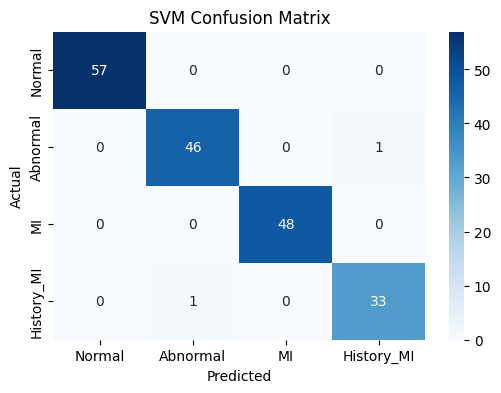

⚠️ SVM accuracy did not improve. Previous: 98.92%, Current: 98.92%

🔷 Training and evaluating K-NN...

✅ K-NN Accuracy: 97.85%

📊 Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98        57
    Abnormal       0.98      0.94      0.96        47
          MI       1.00      1.00      1.00        48
  History_MI       0.97      0.97      0.97        34

    accuracy                           0.98       186
   macro avg       0.98      0.98      0.98       186
weighted avg       0.98      0.98      0.98       186



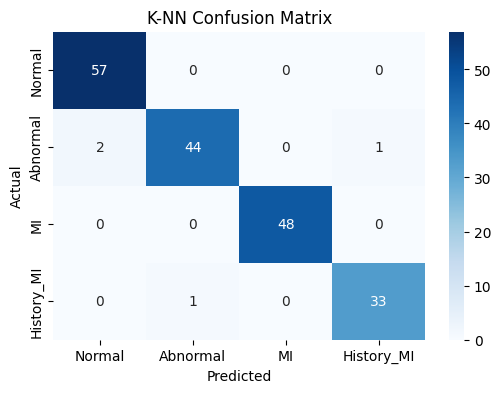

⚠️ K-NN accuracy did not improve. Previous: 97.85%, Current: 97.85%

🔷 Training and evaluating Decision Tree...

✅ Decision Tree Accuracy: 97.85%

📊 Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.96      0.97        57
    Abnormal       1.00      0.96      0.98        47
          MI       1.00      1.00      1.00        48
  History_MI       0.92      1.00      0.96        34

    accuracy                           0.98       186
   macro avg       0.98      0.98      0.98       186
weighted avg       0.98      0.98      0.98       186



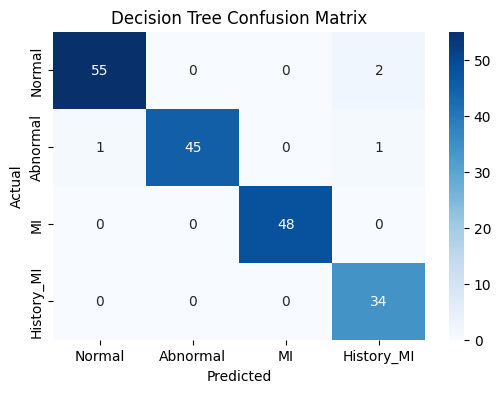

⚠️ Decision Tree accuracy did not improve. Previous: 97.85%, Current: 97.85%

🔷 Training and evaluating Random Forest...

✅ Random Forest Accuracy: 98.39%

📊 Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99        57
    Abnormal       1.00      0.94      0.97        47
          MI       1.00      1.00      1.00        48
  History_MI       0.94      1.00      0.97        34

    accuracy                           0.98       186
   macro avg       0.98      0.98      0.98       186
weighted avg       0.98      0.98      0.98       186



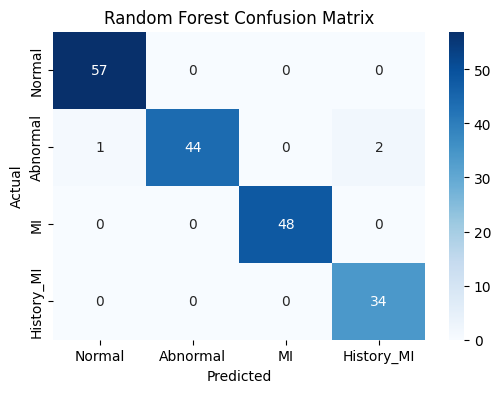

⚠️ Random Forest accuracy did not improve. Previous: 98.92%, Current: 98.39%

🔷 Training and evaluating Naive Bayes...

✅ Naive Bayes Accuracy: 97.31%

📊 Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99        57
    Abnormal       0.96      0.94      0.95        47
          MI       1.00      1.00      1.00        48
  History_MI       0.94      0.94      0.94        34

    accuracy                           0.97       186
   macro avg       0.97      0.97      0.97       186
weighted avg       0.97      0.97      0.97       186



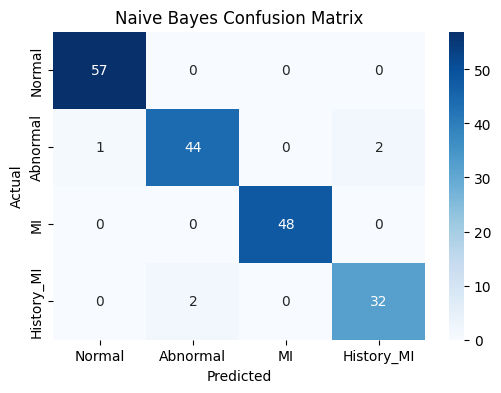

⚠️ Naive Bayes accuracy did not improve. Previous: 97.31%, Current: 97.31%

🔷 Training and evaluating XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



✅ XGBoost Accuracy: 98.92%

📊 Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99        57
    Abnormal       1.00      0.96      0.98        47
          MI       1.00      1.00      1.00        48
  History_MI       0.97      1.00      0.99        34

    accuracy                           0.99       186
   macro avg       0.99      0.99      0.99       186
weighted avg       0.99      0.99      0.99       186



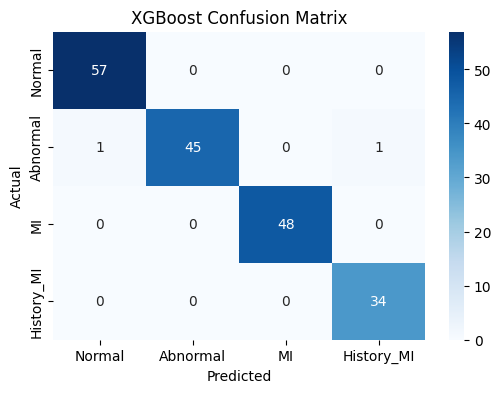

⚠️ XGBoost accuracy did not improve. Previous: 98.92%, Current: 98.92%

🔷 Training and evaluating LightGBM...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



✅ LightGBM Accuracy: 99.46%

📊 Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        57
    Abnormal       1.00      0.98      0.99        47
          MI       1.00      1.00      1.00        48
  History_MI       0.97      1.00      0.99        34

    accuracy                           0.99       186
   macro avg       0.99      0.99      0.99       186
weighted avg       0.99      0.99      0.99       186



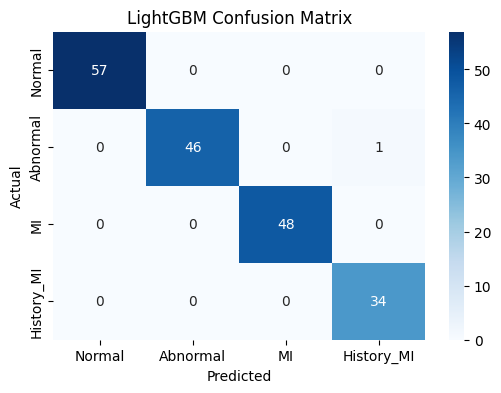

⚠️ LightGBM accuracy did not improve. Previous: 99.46%, Current: 99.46%

🚀 All models evaluated and best models saved successfully!


In [13]:
import pickle
import json
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model, Model

# Load the trained CNN model
best_model = load_model('/content/drive/MyDrive/CIP/MODEL/best_model.h5')
best_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Feature extraction model (third last layer)
feature_extractor = Model(inputs=best_model.input, outputs=best_model.layers[-3].output)

# Extract features
X_train_features = feature_extractor.predict(X_train, verbose=1)
X_val_features = feature_extractor.predict(X_val, verbose=1)

# Standardize the features (important for SVM, KNN, etc.)
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_val_features = scaler.transform(X_val_features)

# Save the scaler for future inference use
with open('/content/drive/MyDrive/CIP/MODEL/feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# File to store best accuracy records
best_accuracy_file = '/content/drive/MyDrive/CIP/MODEL/best_classifier_accuracy.json'
best_accuracies = {}

# Load previous accuracy record if exists
if os.path.exists(best_accuracy_file):
    with open(best_accuracy_file, 'r') as f:
        best_accuracies = json.load(f)

# Classifiers with adjusted parameters
models = {
    "SVM": SVC(class_weight='balanced', probability=True, random_state=42),
    "K-NN": KNeighborsClassifier(n_neighbors=5, metric='minkowski'),  # Can optimize k later
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=200, learning_rate=0.05, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
}

# Class names for reports
class_names = ["Normal", "Abnormal", "MI", "History_MI"]

# Training and evaluation loop
for name, clf in models.items():
    print(f"\n🔷 Training and evaluating {name}...")

    # Fit classifier
    clf.fit(X_train_features, y_train)

    # Predict
    y_pred = clf.predict(X_val_features)

    # Accuracy and Reports
    accuracy = accuracy_score(y_val, y_pred)
    print(f"\n✅ {name} Accuracy: {accuracy * 100:.2f}%")
    print("\n📊 Classification Report:")
    print(classification_report(y_val, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Check and save improved model
    prev_best = best_accuracies.get(name, 0.0)
    if accuracy > prev_best:
        print(f"🆙 {name} accuracy improved from {prev_best * 100:.2f}% to {accuracy * 100:.2f}%. Saving model...")
        with open(f'/content/drive/MyDrive/CIP/MODEL/{name}_classifier.pkl', 'wb') as f:
            pickle.dump(clf, f)
        best_accuracies[name] = accuracy
    else:
        print(f"⚠️ {name} accuracy did not improve. Previous: {prev_best * 100:.2f}%, Current: {accuracy * 100:.2f}%")

# Save updated best accuracies
with open(best_accuracy_file, 'w') as f:
    json.dump(best_accuracies, f)

print("\n🚀 All models evaluated and best models saved successfully!")


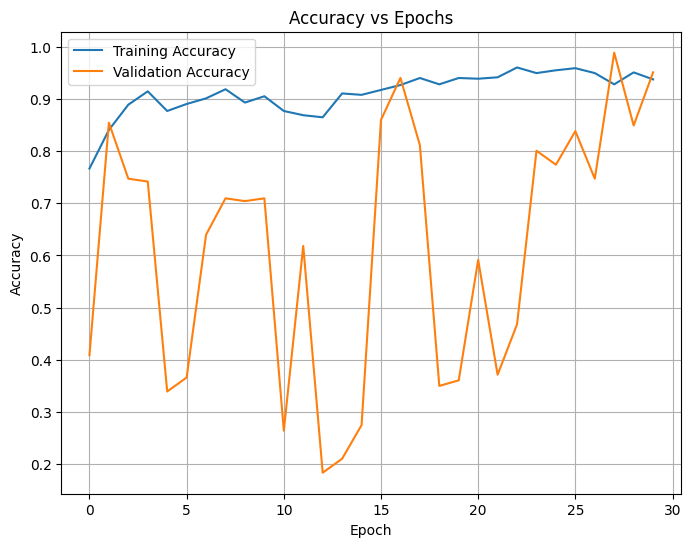

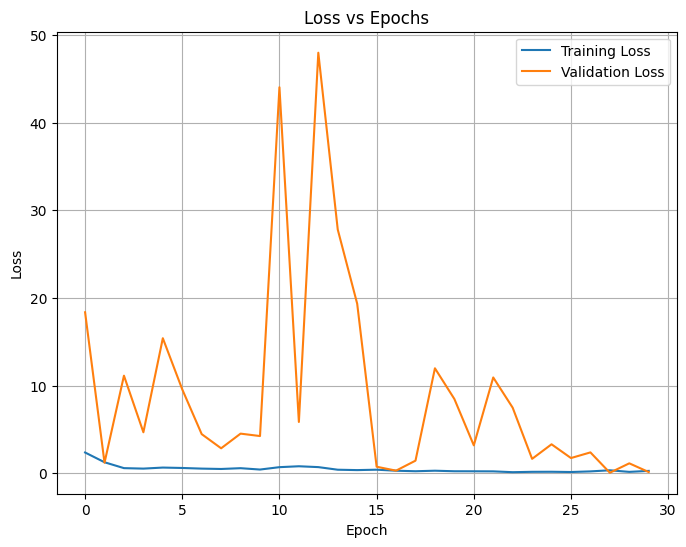

In [9]:
import pickle
import matplotlib.pyplot as plt

# Load training history
with open('/content/drive/MyDrive/CIP/MODEL/training_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Plot Accuracy vs Epochs
plt.figure(figsize=(8, 6))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss vs Epochs
plt.figure(figsize=(8, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pickle
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the best model (CNN for feature extraction)
best_model = load_model('/content/drive/MyDrive/CIP/MODEL/best_model.h5')

# Load the trained classifiers
models = {}
for name in ["SVM", "K-NN", "Decision Tree", "Random Forest", "Naive Bayes", "XGBoost", "LightGBM"]:
    with open(f'/content/drive/MyDrive/CIP/MODEL/{name}_classifier.pkl', 'rb') as f:
        models[name] = pickle.load(f)

# Load and preprocess the single image
def preprocess_image(image_path, target_size=(227, 227)):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Unable to read image from {image_path}")

    # Resize the image
    image = cv2.resize(image, target_size)

    # Normalize the image (if required)
    image = image / 255.0

    # Expand dimensions to match the input shape of the model
    image = np.expand_dims(image, axis=0)

    return image

# Path to the single image
single_image_path = "/content/drive/MyDrive/CIP/MODEL/ECG_Dataset/Normal/Normal(100).jpg"  # Replace with the path to your image

# Preprocess the single image
preprocessed_image = preprocess_image(single_image_path)

# Extract features using the CNN model
feature_extractor = Model(inputs=best_model.input, outputs=best_model.layers[-3].output)
image_features = feature_extractor.predict(preprocessed_image)

# Predict using the classifiers
for name, clf in models.items():
    prediction = clf.predict(image_features)
    #print(f"{name} Prediction: {prediction[0]}")

# Optional: Map predicted class index to class name
class_names = {
    0: "Normal",
    1: "Abnormal",
    2: "MI",
    3: "History_MI"
}

for name, clf in models.items():
    prediction = clf.predict(image_features)
    print(f"{name} Prediction: {class_names[prediction[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
SVM Prediction: Normal
K-NN Prediction: Normal
Decision Tree Prediction: Normal
Random Forest Prediction: Normal
Naive Bayes Prediction: Normal
XGBoost Prediction: Normal
LightGBM Prediction: Normal


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
